In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import math

In [3]:
%matplotlib inline
import ternary

In [4]:
def sigmoid(x,centre,sharpness):
    return np.exp(sharpness*(x-centre))/(1+np.exp(sharpness*(x-centre)))

In [5]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)

In [24]:
def colour_points(points,alpha):
    # assumes points sum to 1 row-wise
    colours = []
    for i in points:
        colours.append((i[0],i[1],i[2],alpha))
    return colours

In [6]:
def corner_colours(x,y,z,centre,sharpness):
    x_color = sigmoid(x,centre,sharpness)
    y_color = sigmoid(y,centre,sharpness)
    z_color = sigmoid(z,centre,sharpness)
    return (x_color, y_color, z_color, 1.)

In [7]:
def generate_heatmap_data(scale, resolution=2):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale*resolution):
        d[(i/resolution, j/resolution, k/resolution)] = color_point(i/resolution, j/resolution, k/resolution, scale)
    return d

In [8]:
# Make images higher resolution and set default size
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams['figure.facecolor'] = '1.0'
import matplotlib.pyplot as plt

In [9]:
a = 0.05
t = np.arange(-10,10.5,0.05)
x = np.log(1 + np.exp(np.cos(t) / np.sqrt(1+a*a*t*t)))
y = np.log(1+ np.exp(np.sin(t) / np.sqrt(1+a*a*t*t)))
z = np.log(1+ np.exp(- a*t / np.sqrt(1+a*a*t*t)))
m = x + y + z
colour_points = np.stack((x/m, y/m, z/m), axis = 0)
points = np.stack((x/m, y/m, z/m), axis = 1)

In [31]:
from matplotlib import colors as mcolors

In [32]:
colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

In [33]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

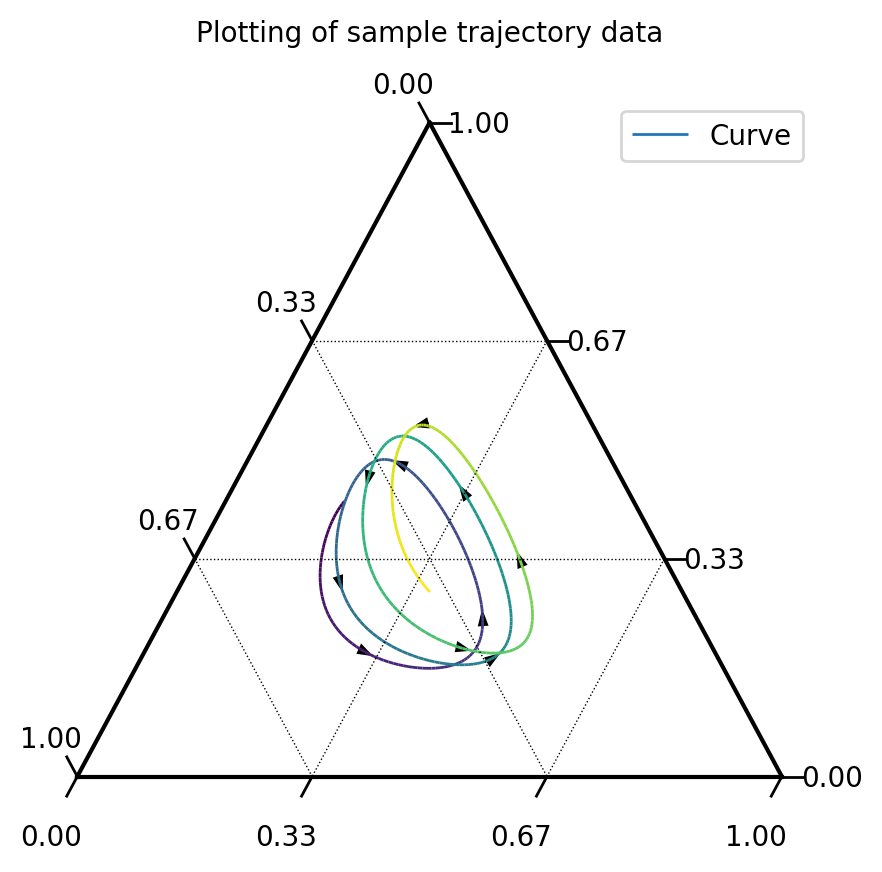

In [34]:
## Sample trajectory plot
figure, tax = ternary.figure(scale=1)
figure.set_size_inches(5, 5)

tax.boundary()
tax.gridlines(multiple=1./3, color="black")
tax.set_title("Plotting of sample trajectory data", fontsize=10, pad=20)

#tax.plot_colored_trajectory(points, cmap="hsv", linewidth=1.0, label="Mix")
tax.plot_colored_trajectory(points, colors=colors, linewidth=1.0, label="Curve")
tax.arrow(points, arrows=10, shape='full', lw=1, length_includes_head=True, head_width=.01)
tax.ticks(axis='lbr', multiple=1./3, linewidth=1, tick_formats="%.2f", offset=0.03)

tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()

In [11]:
def plot_colored_traj(points, cmap=None, ax=None, permutation=None,
                            **kwargs):
    """
    Plots trajectories with changing color, simlar to `plot`. Trajectory points
    are tuples (x,y,z) satisfying x + y + z = scale (not checked). The tuples are
    projected and plotted as a curve.
    Parameters
    ----------
    points: List of 3-tuples
        The list of tuples to be plotted as a connected curve.
    ax: Matplotlib AxesSubplot, None
        The subplot to draw on.
    cmap: String or matplotlib.colors.Colormap, None
        The name of the Matplotlib colormap to use.
    kwargs:
        Any kwargs to pass through to matplotlib.
    """
    if not ax:
        fig, ax = pyplot.subplots()
    cmap = get_cmap(cmap)
    xs, ys = project_sequence(points, permutation=permutation)

    # We want to color each segment independently...which is annoying.
    segments = []
    for i in range(len(xs) - 1):
        cur_line = []
        x_before = xs[i]
        y_before = ys[i]
        x_after = xs[i+1]
        y_after = ys[i+1]

        cur_line.append([x_before, y_before])
        cur_line.append([x_after, y_after])
        segments.append(cur_line)
    segments = np.array(segments)

    line_segments = matplotlib.collections.LineCollection(segments, cmap=cmap, **kwargs)
    line_segments.set_array(np.arange(len(segments)))
    ax.add_collection(line_segments)

    return ax
